In [1]:
import knapsack as knap
import ast
import timeit
import time
import glob
import pandas
import numpy
from matplotlib import pyplot
from matplotlib.ticker import FormatStrFormatter
from functools import partial

In [2]:
%matplotlib inline

## The Data

In [3]:
def read_all_instances():
    instances = dict()
    for filename in glob.iglob('data/knap_??.inst.dat'):
        with open(filename) as f:
            instances.update(knap.read_instances(f))

    return pandas.DataFrame.from_dict(instances, orient='index')

In [4]:
def read_solutions(f):
    data = {}
    for line in f.readlines():
        items = list(map(int, line.split()))
        data[items[0]] = {
            'solution_value': items[2],
            'solution': items[3:]
        }
    return data

In [5]:
def read_all_solutions():
    solutions = dict()
    for filename in glob.iglob('data/knap_??.sol.dat'):
        with open(filename) as f:
            solutions.update(read_solutions(f))
    return pandas.DataFrame.from_dict(solutions, orient='index')

In [6]:
# df = pandas.concat([inst_df, sol_df], axis=1)

In [7]:
def backup_dataframe():
    # save DataFrame
    df.to_csv('data/dataframe-backup.csv')

In [8]:
# restore DataFrame
generic = lambda x: ast.literal_eval(x)
converters = {
    'weights': generic,
    'values': generic,
    'solution': generic
}
df = pandas.read_csv('data/dataframe-backup.csv', index_col=0, converters=converters)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 9000 to 9599
Data columns (total 14 columns):
n                            600 non-null int64
m                            600 non-null int64
weights                      600 non-null object
values                       600 non-null object
heuristic_time               600 non-null float64
brute_force_time             300 non-null float64
solution_value               600 non-null int64
solution                     600 non-null object
heuristic_value              600 non-null float64
relative_error               600 non-null float64
branch_and_bound_time        600 non-null float64
branch_and_bound_value       600 non-null float64
dynamic_programming_value    600 non-null float64
dynamic_programming_time     600 non-null float64
dtypes: float64(8), int64(3), object(3)
memory usage: 70.3+ KB


,n,m,weights,values,heuristic_time,brute_force_time,solution_value,solution,heuristic_value,relative_error,branch_and_bound_time,branch_and_bound_value,dynamic_programming_value,dynamic_programming_time
9000,4,100,"[18, 42, 88, 3]","[114, 136, 192, 223]",0.000037,0.000055,473,"[1, 1, 0, 1]",473.0,0.000000,0.000030,473.0,473.0,0.031192
9001,4,100,"[55, 81, 14, 52]","[29, 64, 104, 222]",0.000030,0.000055,326,"[0, 0, 1, 1]",326.0,0.000000,0.000037,326.0,326.0,0.016173
9002,4,100,"[89, 18, 57, 69]","[196, 62, 34, 112]",0.000027,0.000051,196,"[1, 0, 0, 0]",174.0,0.112245,0.000040,196.0,196.0,0.015611
9003,4,100,"[34, 23, 62, 2]","[169, 152, 44, 224]",0.000029,0.000059,545,"[1, 1, 0, 1]",545.0,0.000000,0.000035,545.0,545.0,0.022405
9004,4,100,"[67, 74, 87, 65]","[145, 111, 139, 243]",0.000023,0.000061,243,"[0, 0, 0, 1]",243.0,0.000000,0.000030,243.0,243.0,0.023797


In [9]:
ns = [4, 10, 15, 20, 22, 25, 27, 30, 32, 35, 37, 40]

In [10]:
def time_instances(fn, ns, df, time_column):
    for n in ns:
        for idx, inst in df[df['n'] == n].iterrows():
            global inst_fn  # TODO global allows to make import from __main__
            inst_fn = partial(fn, *inst[['n', 'm', 'weights', 'values']])
            timer = timeit.Timer('inst_fn()', setup='from __main__ import inst_fn', timer=time.process_time)
            t = timer.timeit(number=1)
            df.loc[idx, time_column] = t
            print(idx, inst['n'], t)

## Brute Force

In [11]:
time_instances(knap.brute_force, [], df, 'brute_force_time')

## Heuristic

In [12]:
time_instances(knap.heuristic, [], df, 'heuristic_time')

In [13]:
def solve_instances(fn, ns, df, solution_column):
    for n in ns:
        for idx, inst in df[df['n'] == n].iterrows():
            value, _ = fn(*inst[['n', 'm', 'weights', 'values']])
            df.loc[idx, solution_column] = value
            print(idx, inst['n'], value)

In [14]:
solve_instances(knap.heuristic, [], df, 'heuristic_value')

### Relative Error

In [15]:
df['relative_error'] = (df['solution_value'] - df['heuristic_value']) / df['solution_value']

In [16]:
group = df.groupby(by='n')['relative_error']
mean_error = group.mean()
max_error = group.max()

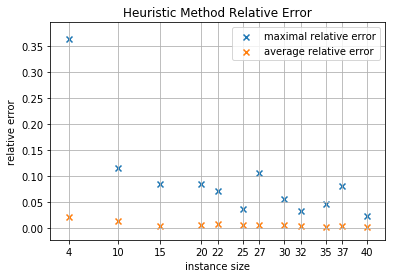

In [17]:
ax = pyplot.subplot()
ax.set_title('Heuristic Method Relative Error')
ax.scatter(ns, max_error, marker='x', label='maximal relative error')
ax.scatter(ns, mean_error, marker='x', label='average relative error')
ax.set_xticks(ns)
ax.set_ylabel('relative error')
ax.set_xlabel('instance size')
ax.legend()
ax.grid()

pyplot.savefig('reports/img/heuristic_relative_error.pdf')

## Branch and Bound Method

In [18]:
time_instances(knap.branch_and_bound, [], df, 'branch_and_bound_time')

In [19]:
solve_instances(knap.branch_and_bound, [], df, 'branch_and_bound_value')
(df['branch_and_bound_value'] == df['solution_value']).all()

True

## Dynamic Programming

In [20]:
time_instances(knap.dynamic_programming, [], df, 'dynamic_programming_time')

In [21]:
solve_instances(knap.dynamic_programming, [], df, 'dynamic_programming_value')
(df['dynamic_programming_value'] == df['solution_value']).all()

True

## Time Plot

In [22]:
times_idx = ['brute_force_time', 'heuristic_time', 'branch_and_bound_time', 'dynamic_programming_time']
times_group = df.groupby(by='n')[times_idx]
times_mean = times_group.mean()
times_std = times_group.std()
times_mean

,brute_force_time,heuristic_time,branch_and_bound_time,dynamic_programming_time
n,,,,
4,0.000038,0.000026,0.000034,0.019083
10,0.002232,0.000027,0.000154,0.128957
15,0.102152,0.000035,0.000292,0.226531
20,3.788610,0.000044,0.002855,0.461762
22,16.176022,0.000058,0.008928,0.530528
25,138.542621,0.000064,0.022785,0.704964
27,NaN,0.000055,0.052917,0.772885
30,NaN,0.000059,0.121398,0.942580
32,NaN,0.000070,0.229006,1.069233


In [23]:
times_std

,brute_force_time,heuristic_time,branch_and_bound_time,dynamic_programming_time
n,,,,
4,0.000012,0.000007,0.000010,0.005649
10,0.000404,0.000005,0.000084,0.037941
15,0.014299,0.000011,0.000483,0.042246
20,0.241654,0.000013,0.003897,0.101599
22,0.804018,0.000021,0.013296,0.100791
25,3.342785,0.000021,0.022845,0.154486
27,NaN,0.000017,0.069744,0.137328
30,NaN,0.000016,0.126008,0.148166
32,NaN,0.000022,0.501127,0.196747


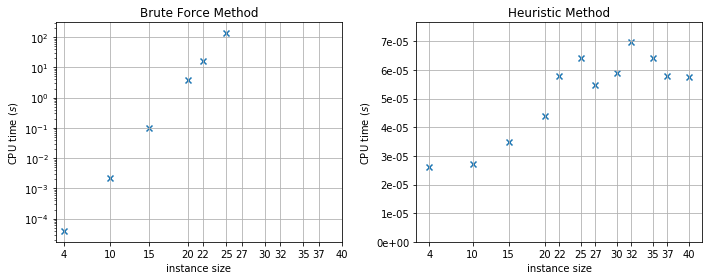

In [24]:
fig, (ax1, ax2) = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 4))
# brute force
ax1.set_yscale('log')
ax1.scatter(ns, times_mean['brute_force_time'], marker='x')
ax1.set_title('Brute Force Method')
ax1.set_xticks(ns)
ax1.set_xlabel('instance size')
ax1.set_ylabel('CPU time ($s$)')
ax1.grid()

# heuristic
ax2.scatter(ns, times_mean['heuristic_time'], marker='x')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.e'))
ax2.set_ylim([0, 1.1 * times_mean['heuristic_time'].max()])
ax2.set_title('Heuristic Method')
ax2.set_xticks(ns)
ax2.set_xlabel('instance size')
ax2.set_ylabel('CPU time ($s$)')
ax2.grid()

fig.tight_layout()
pyplot.savefig('reports/img/brute_force_heuristic_times.pdf')

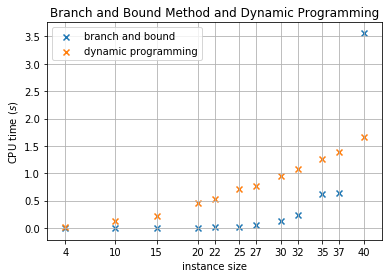

In [25]:
pyplot.scatter(ns, times_mean['branch_and_bound_time'], marker='x', label='branch and bound')
pyplot.scatter(ns, times_mean['dynamic_programming_time'], marker='x', label='dynamic programming')
pyplot.legend()
pyplot.title('Branch and Bound Method and Dynamic Programming')
pyplot.xticks(ns)
pyplot.xlabel('instance size')
pyplot.ylabel('CPU time ($s$)')
pyplot.grid()